##Puttable Swap
Puttable Swap은 스왑 계약의 한 형태로, 특정 조건을 만족할 때 스왑의 한 당사자가 스왑을 조기에 종료할 수 있는 옵션을 가지는 구조입니다.

In [2]:
import matplotlib.font_manager as fm

# Google Colab에 NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 설치된 폰트 확인 및 matplotlib에 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


<ipython-input-4-38b220929b59>:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-4-38b220929b59>:7: RuntimeWarning: invalid value encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


Puttable Swap의 현재 가치: nan


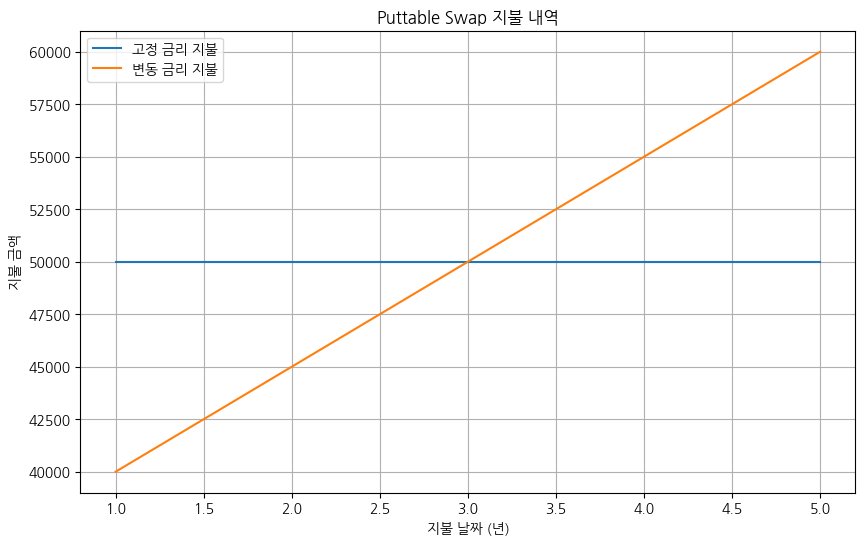

In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# 블랙-숄즈 모델을 사용하여 풋 옵션 가격을 계산하는 함수
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

# 고정 금리 지불 계산 함수
def fixed_leg_payment(notional, fixed_rate, payment_dates):
    payments = notional * fixed_rate * np.diff(payment_dates, prepend=0)
    return payments

# 변동 금리 지불 계산 함수
def floating_leg_payment(notional, floating_rates, payment_dates):
    payments = notional * floating_rates * np.diff(payment_dates, prepend=0)
    return payments

# Puttable Swap의 현재 가치 계산 함수
def puttable_swap_value(notional, fixed_rate, floating_rates, swap_start, swap_end, payment_dates, discount_factors, put_date, put_strike, volatility):
    """
    notional: 명목 금액
    fixed_rate: 고정 금리
    floating_rates: 변동 금리 배열
    swap_start: 스왑 시작 시점
    swap_end: 스왑 종료 시점
    payment_dates: 지불 날짜 배열
    discount_factors: 할인율 배열
    put_date: 풋 옵션 행사 날짜
    put_strike: 풋 옵션 행사가격
    volatility: 변동성
    """
    # 고정 금리 지불 계산
    fixed_leg_payments = fixed_leg_payment(notional, fixed_rate, payment_dates)

    # 변동 금리 지불 계산
    floating_leg_payments = floating_leg_payment(notional, floating_rates, payment_dates)

    # 스왑의 현재 가치 계산
    swap_value = np.sum((floating_leg_payments - fixed_leg_payments) * discount_factors)

    # 풋 옵션의 가치 계산 (스왑을 조기에 종료할 수 있는 권리)
    time_to_put = put_date - swap_start
    option_value = black_scholes_put(swap_value, put_strike, time_to_put, np.mean(discount_factors), volatility)

    return swap_value + option_value

# 예시 데이터
notional = 1000000  # 명목 금액
fixed_rate = 0.05  # 고정 금리 (5%)
floating_rates = np.array([0.04, 0.045, 0.05, 0.055, 0.06])  # 변동 금리
swap_start = 0  # 스왑 시작 시점
swap_end = 5    # 스왑 종료 시점 (5년)
payment_dates = np.array([1, 2, 3, 4, 5])  # 지불 날짜 (매년)
discount_factors = np.exp(-0.05 * payment_dates)  # 할인율
put_date = 3  # 풋 옵션 행사 날짜 (3년 후)
put_strike = 0.0  # 풋 옵션 행사가격 (스왑 가치의 행사가격)
volatility = 0.2  # 변동성

# Puttable Swap의 현재 가치 계산
puttable_swap_val = puttable_swap_value(notional, fixed_rate, floating_rates, swap_start, swap_end, payment_dates, discount_factors, put_date, put_strike, volatility)
print(f"Puttable Swap의 현재 가치: {puttable_swap_val:.2f}")

# 시각화
fixed_leg_payments = fixed_leg_payment(notional, fixed_rate, payment_dates)
floating_leg_payments = floating_leg_payment(notional, floating_rates, payment_dates)

plt.figure(figsize=(10, 6))
plt.plot(payment_dates, fixed_leg_payments, label='고정 금리 지불')
plt.plot(payment_dates, floating_leg_payments, label='변동 금리 지불')
plt.xlabel('지불 날짜 (년)')
plt.ylabel('지불 금액')
plt.title('Puttable Swap 지불 내역')
plt.legend()
plt.grid(True)
plt.show()
